In [32]:
# Importações necessárias
import kagglehub
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy.stats import f_oneway
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


In [5]:
# Download e carregamento do dataset
path = kagglehub.dataset_download("mbsoroush/mobile-price-range")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\VipSo\.cache\kagglehub\datasets\mbsoroush\mobile-price-range\versions\1


# Análise exploratória de dados

In [6]:
data_train = pd.read_csv(f"{path}/train.csv")
data_test = pd.read_csv(f"{path}/test.csv")

# Análise exploratória de dados
print(data_train.head())
print(data_train.describe())

   battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   

   mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2  ...         20       756  2549     9     7         19   
1        136        3  ...        905      1988  2631    17     3          7   
2        145        5  ...       1263      1716  2603    11     2          9   
3        131        6  ...       1216      1786  2769    16     8         11   
4        141        2  ...       1208      1212  1411     8     2         15   

   three_g  touch_screen  wifi  price_

## Informações Gerais do Dataset

In [54]:
print(data_train.info())
print(data_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

## Estatisticas Basicas

In [55]:
print(data_train.describe())
print(data_test.describe())

       battery_power       blue  clock_speed     dual_sim           fc  \
count    2000.000000  2000.0000  2000.000000  2000.000000  2000.000000   
mean     1238.518500     0.4950     1.522250     0.509500     4.309500   
std       439.418206     0.5001     0.816004     0.500035     4.341444   
min       501.000000     0.0000     0.500000     0.000000     0.000000   
25%       851.750000     0.0000     0.700000     0.000000     1.000000   
50%      1226.000000     0.0000     1.500000     1.000000     3.000000   
75%      1615.250000     1.0000     2.200000     1.000000     7.000000   
max      1998.000000     1.0000     3.000000     1.000000    19.000000   

            four_g   int_memory        m_dep    mobile_wt      n_cores  ...  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000  ...   
mean      0.521500    32.046500     0.501750   140.249000     4.520500  ...   
std       0.499662    18.145715     0.288416    35.399655     2.287837  ...   
min       0.00000

## Distribuição das Variaveis Numéricas

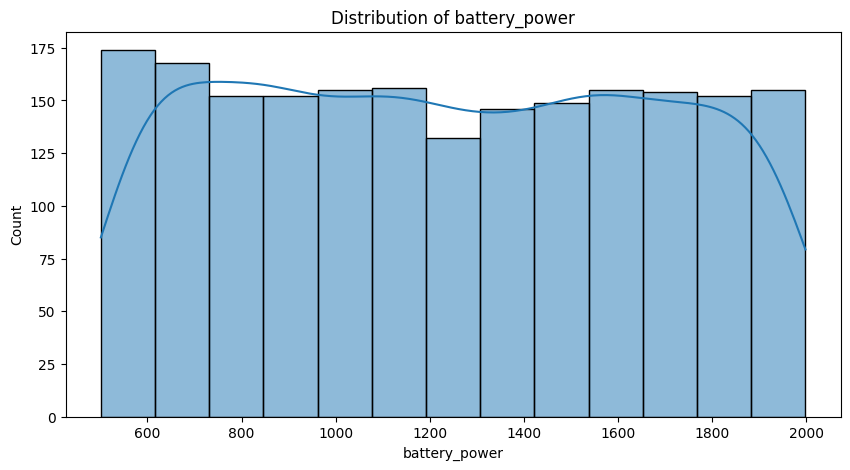

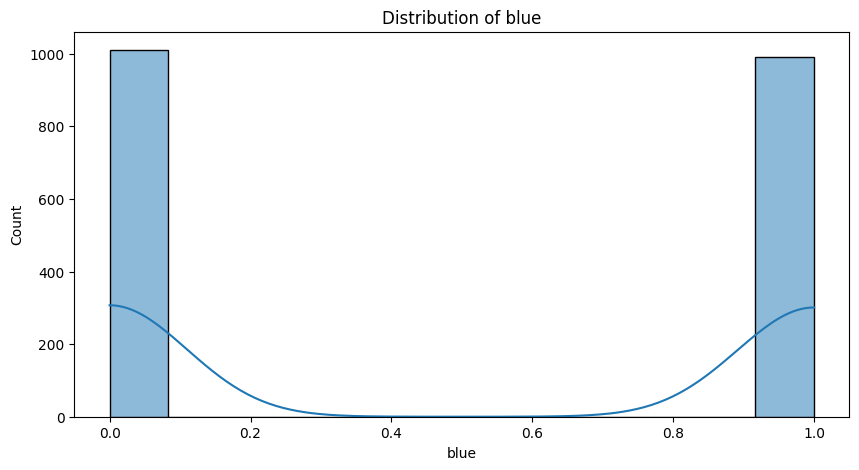

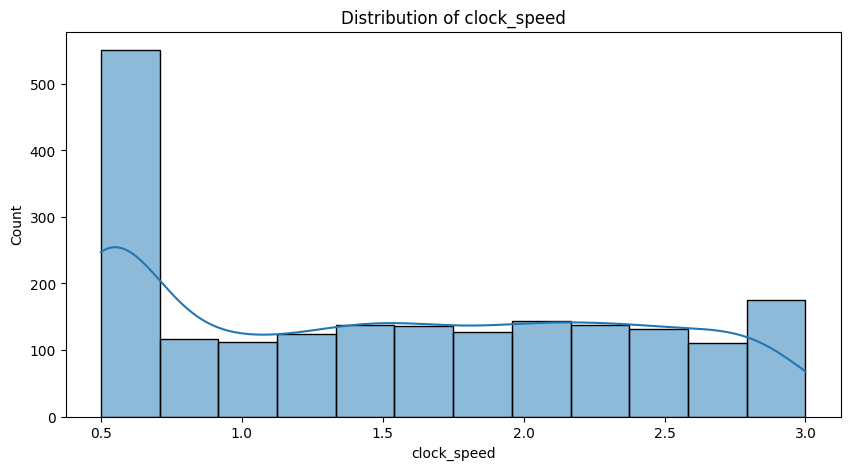

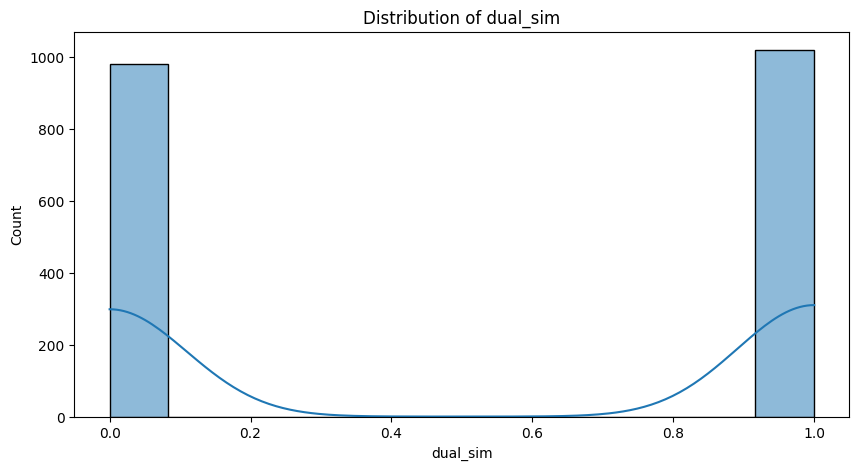

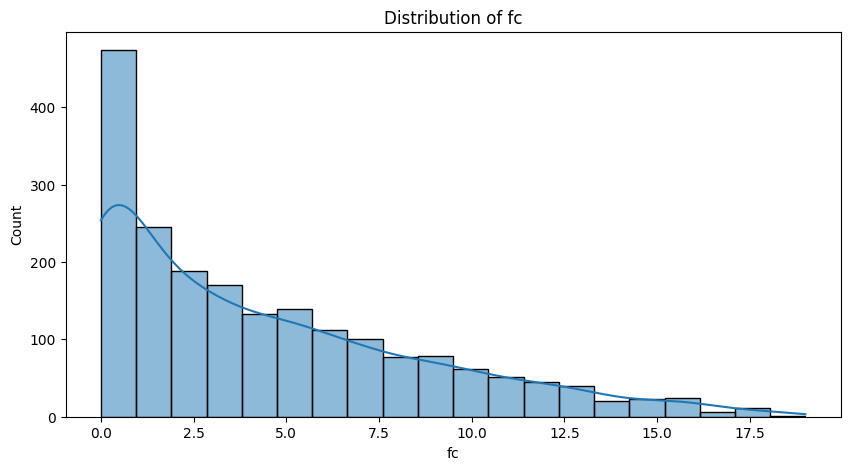

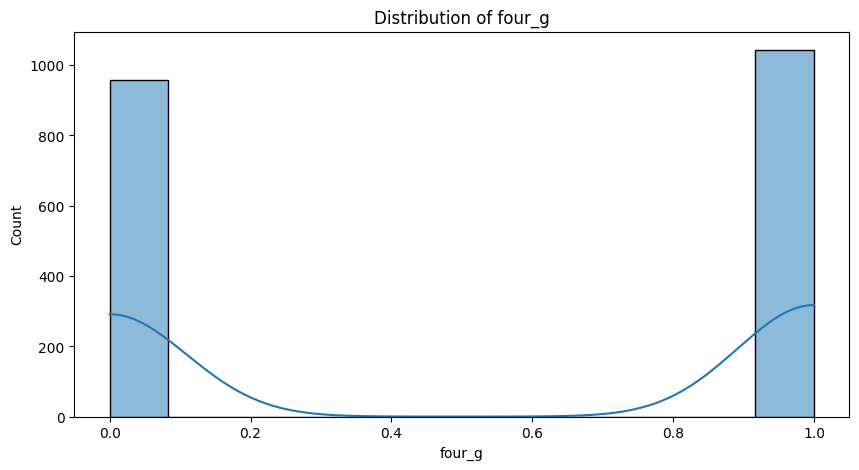

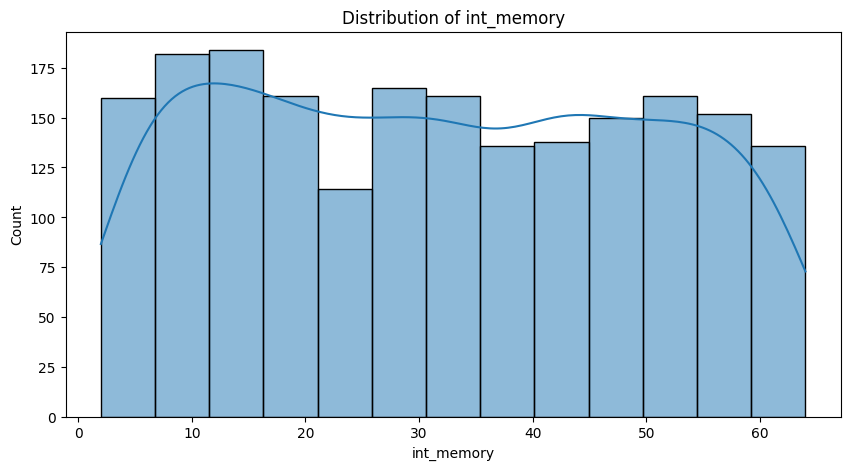

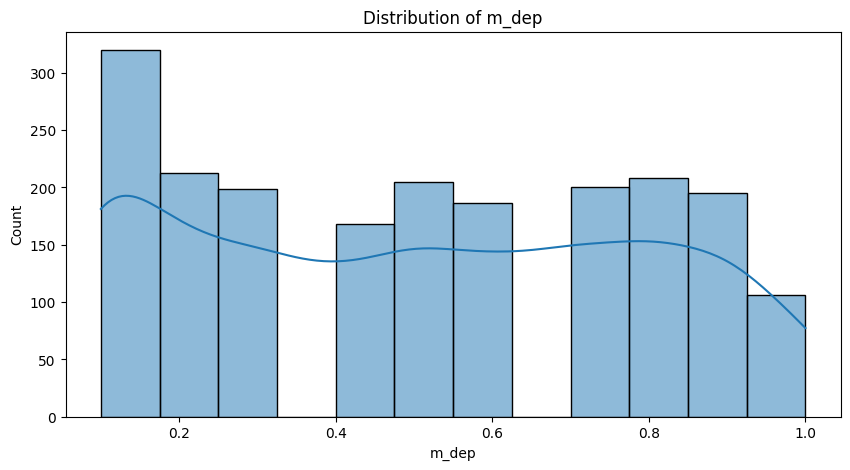

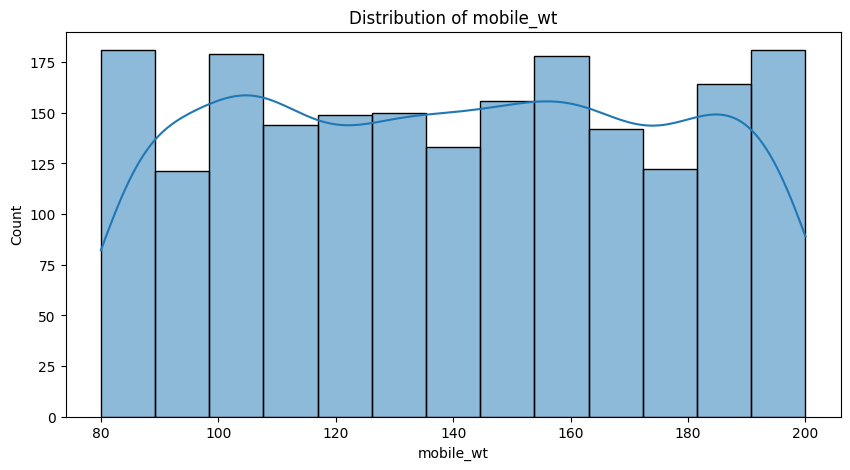

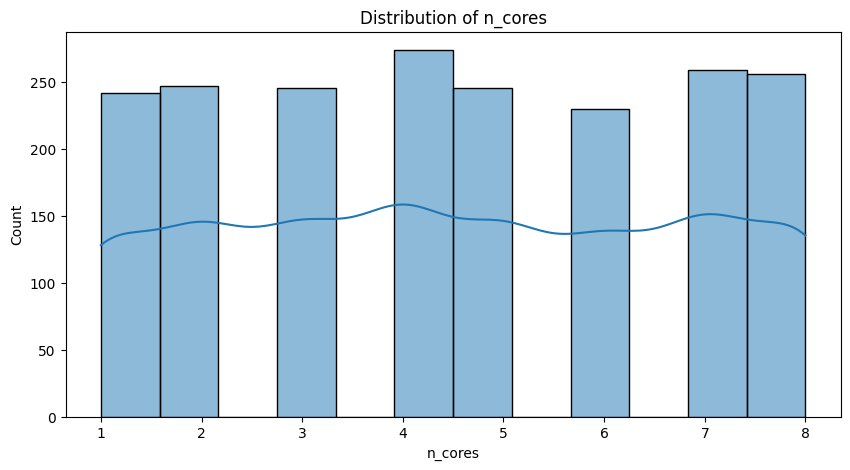

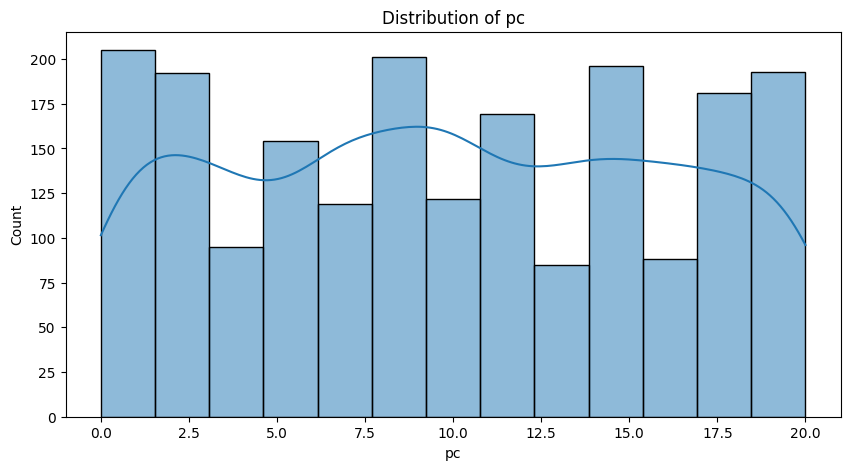

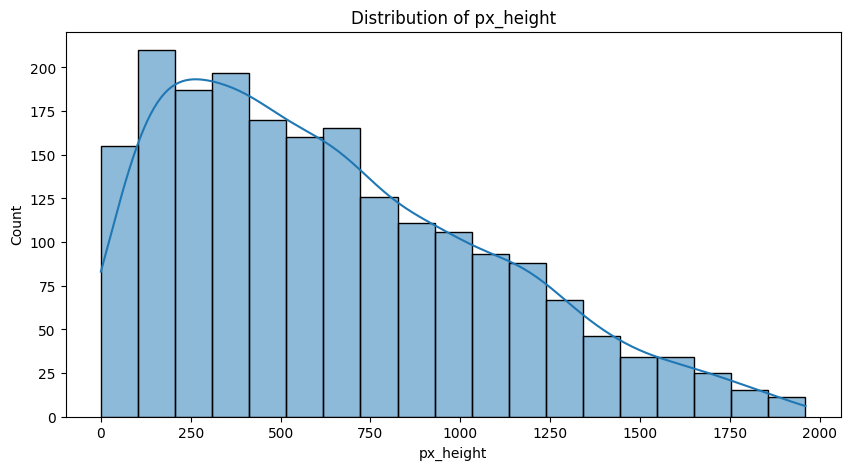

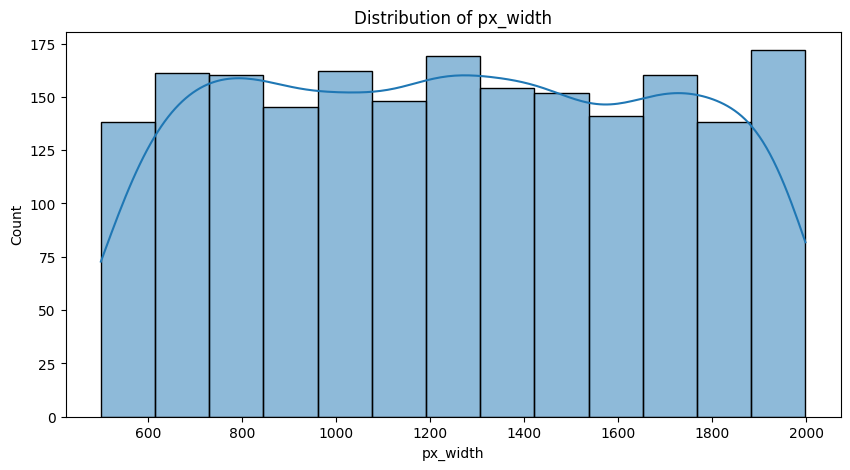

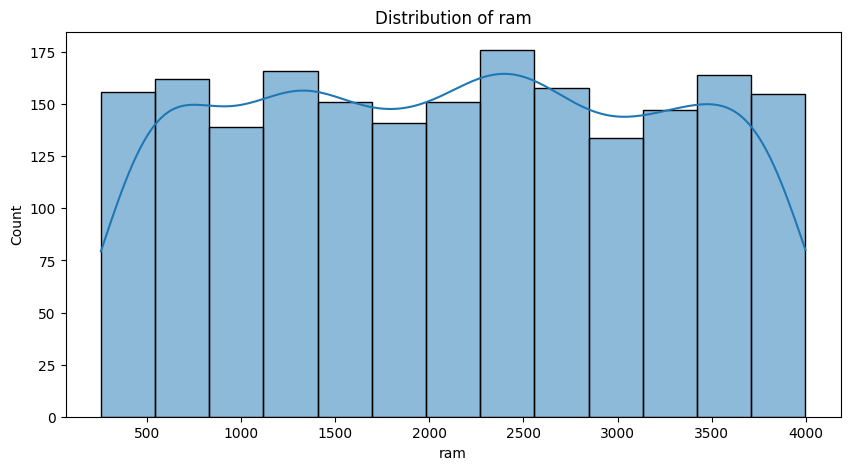

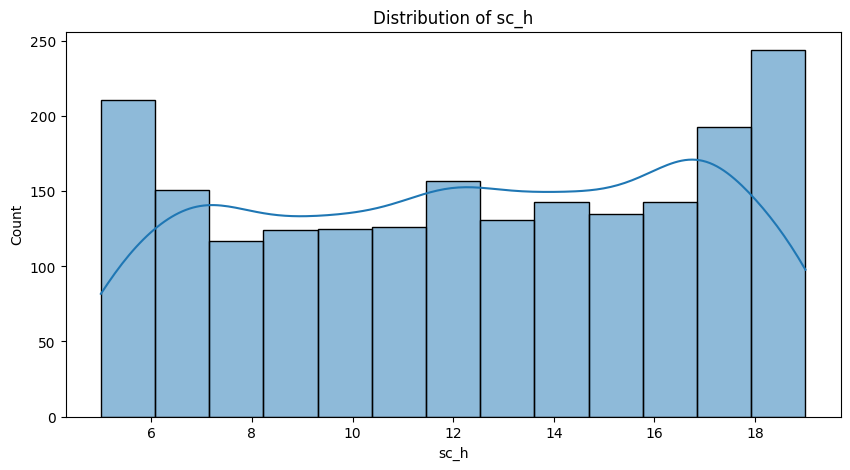

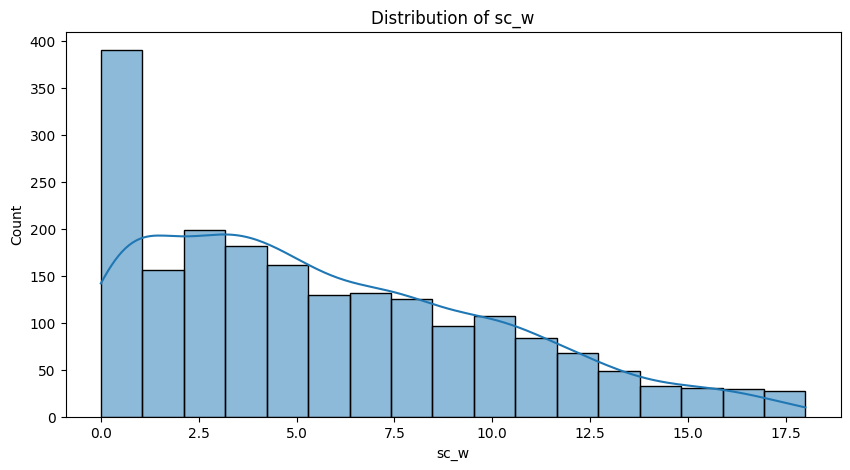

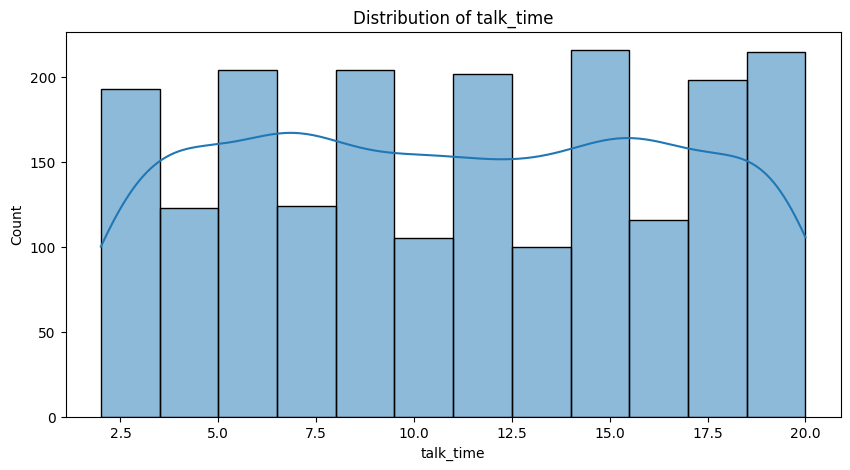

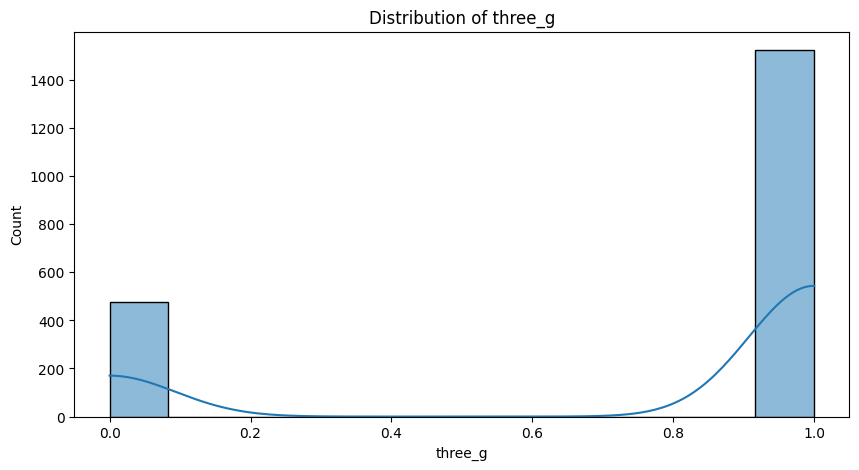

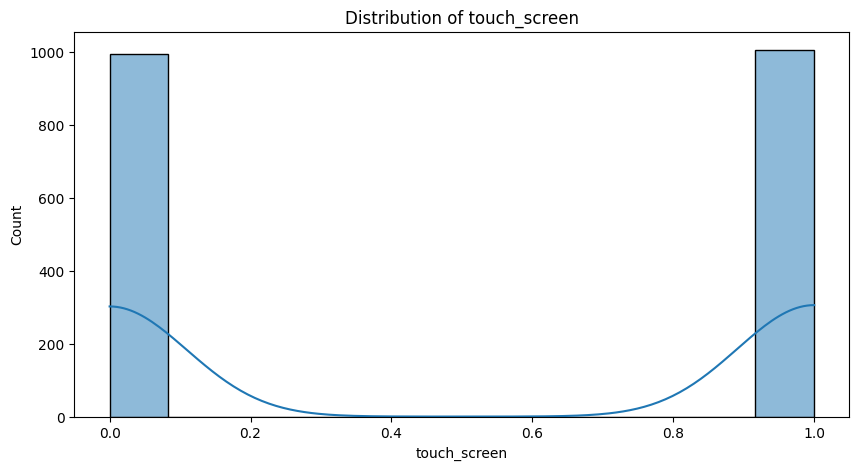

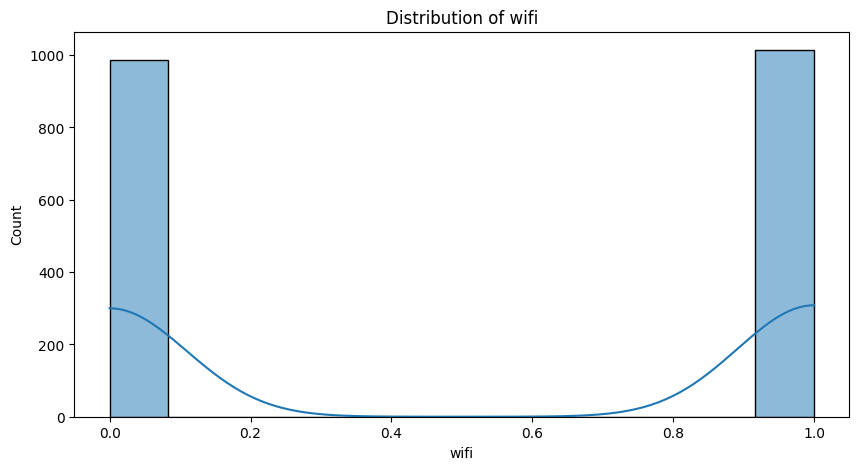

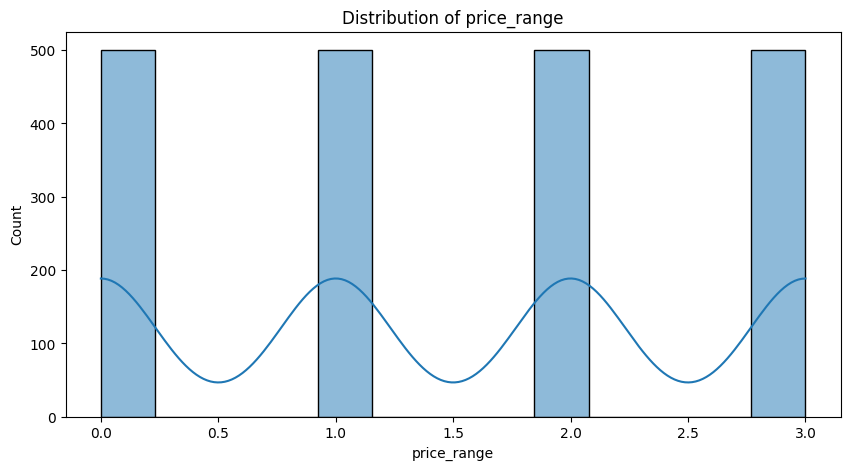

In [60]:
numeric_columns = data_train.select_dtypes(include=[np.number]).columns

for col in numeric_columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=data_train, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

## Analise de Correlação

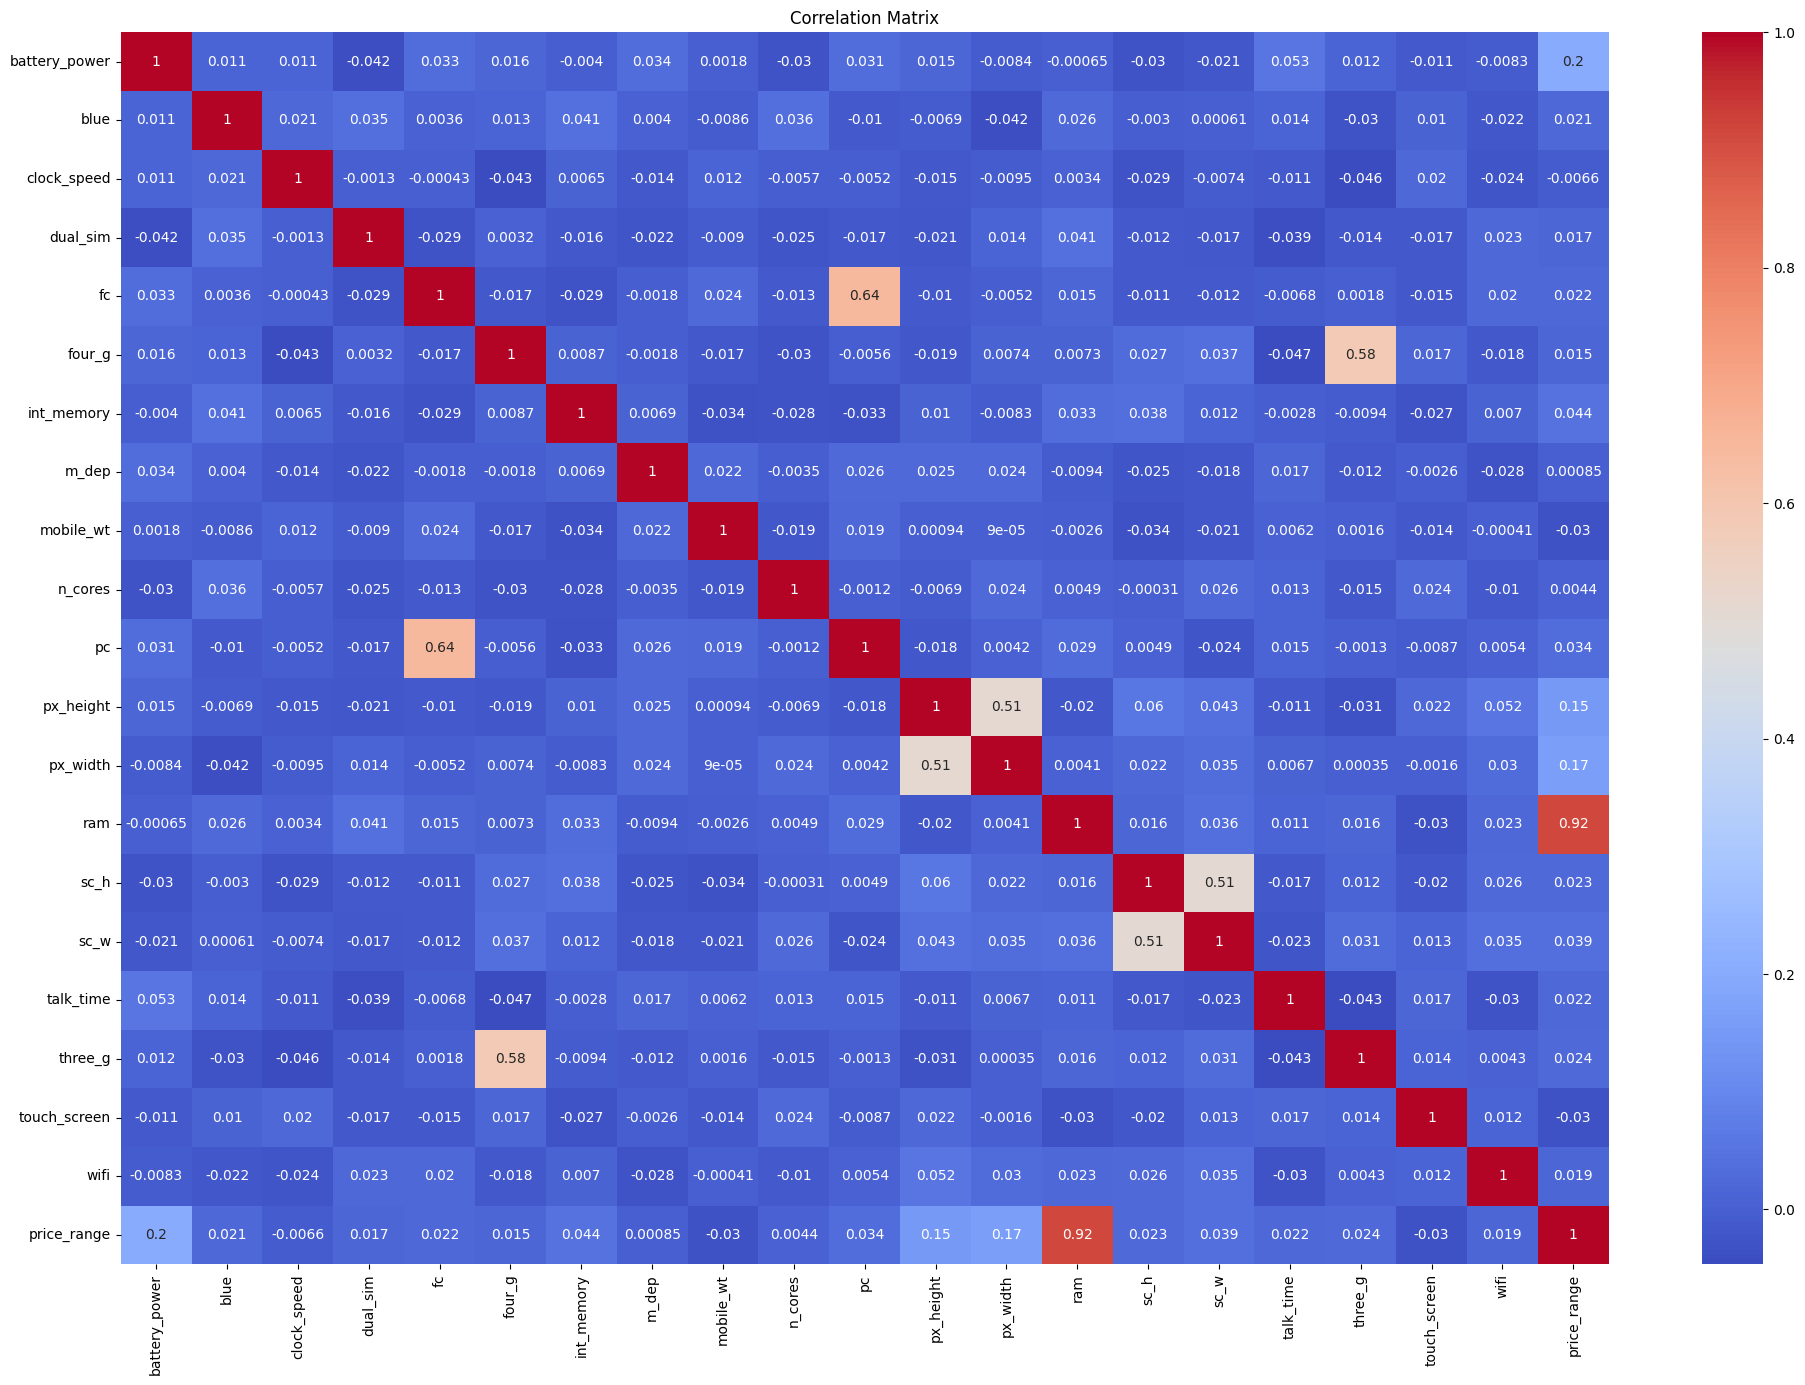

In [58]:
plt.figure(figsize=(24, 16))
correlation_matrix = data_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Analise de Outliers

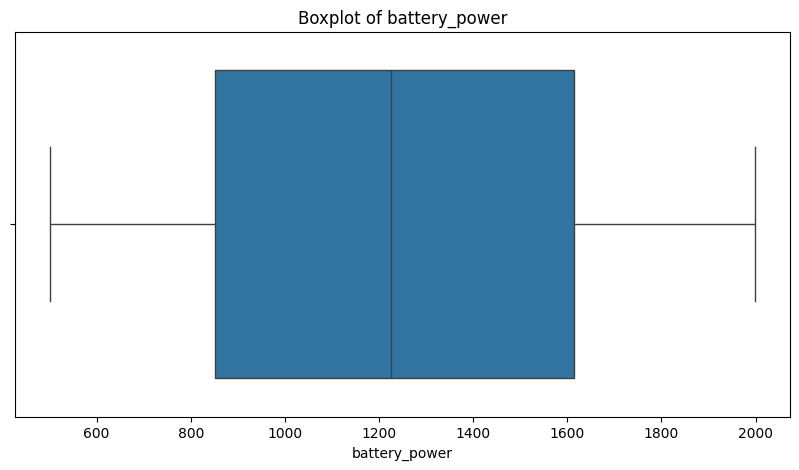

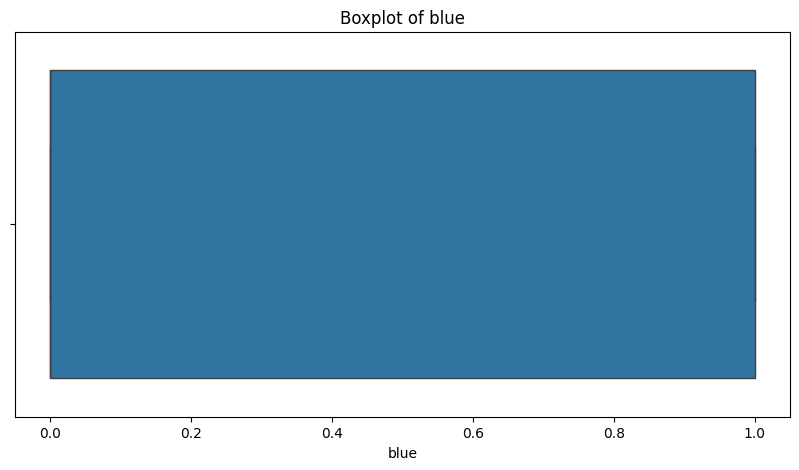

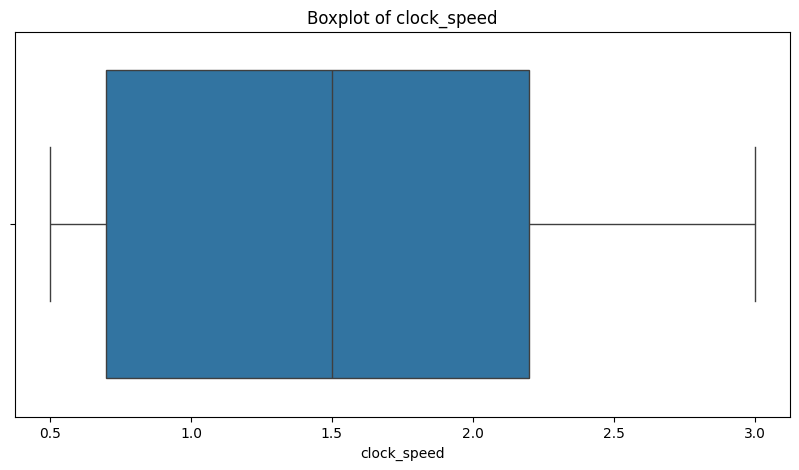

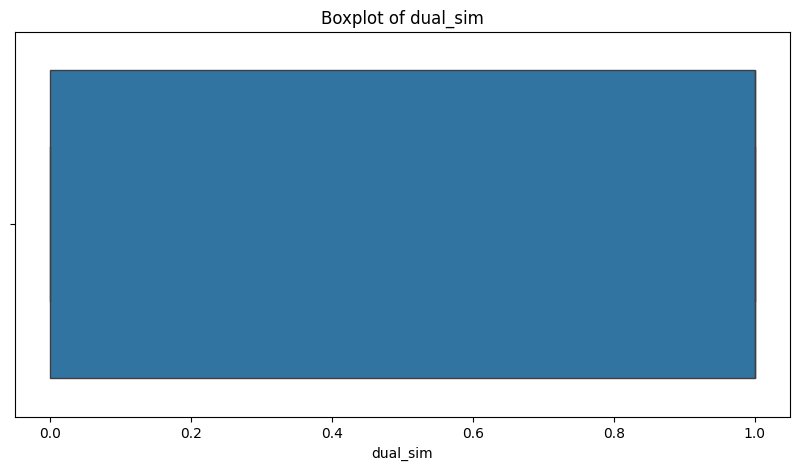

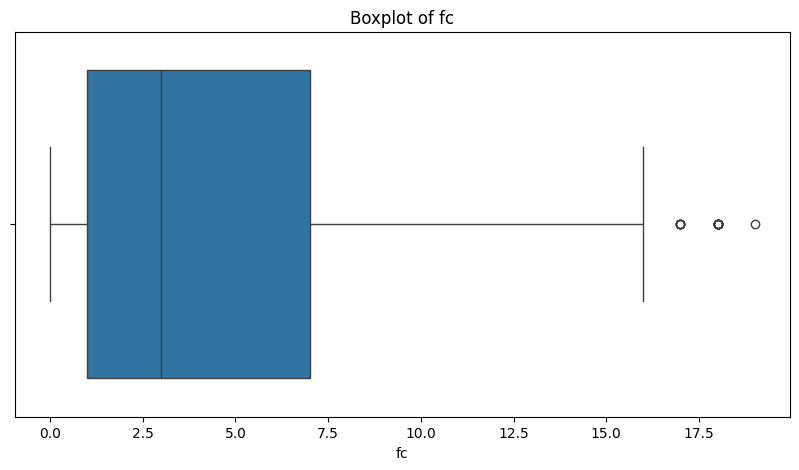

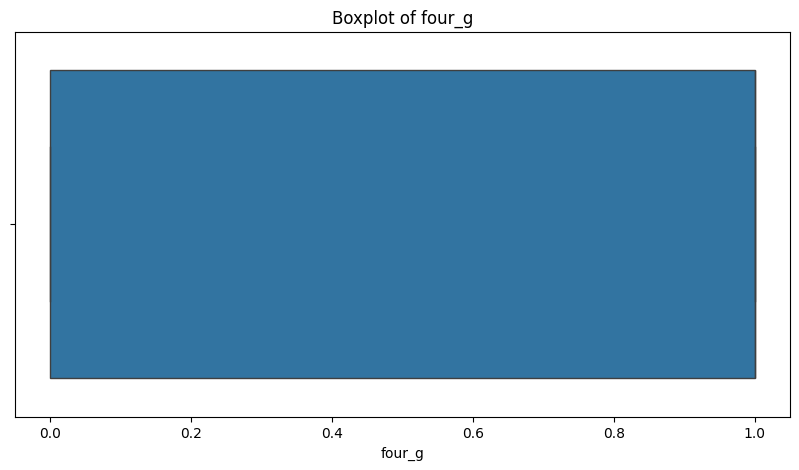

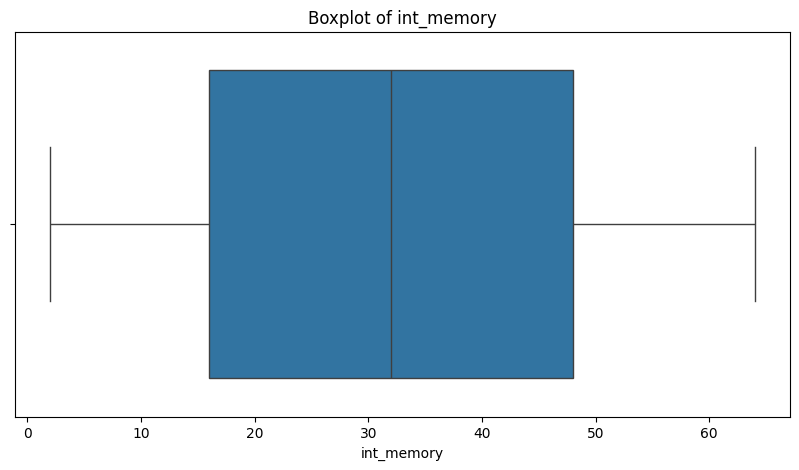

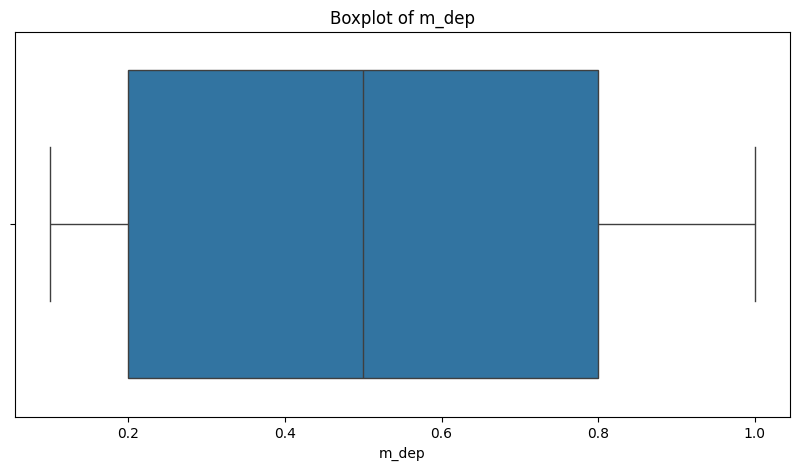

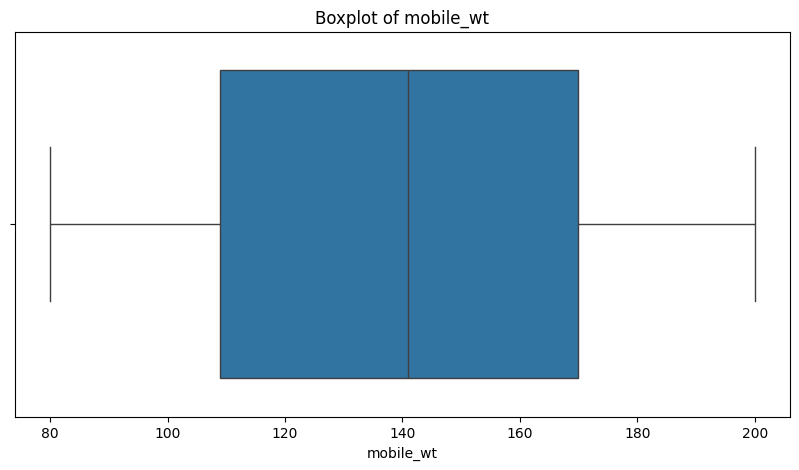

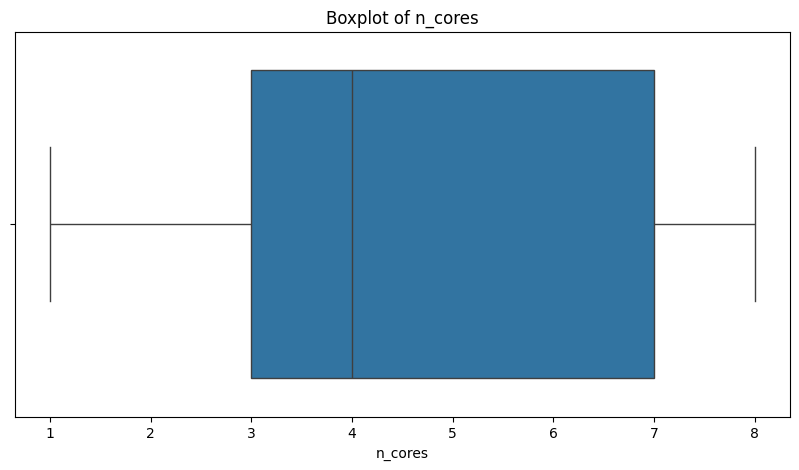

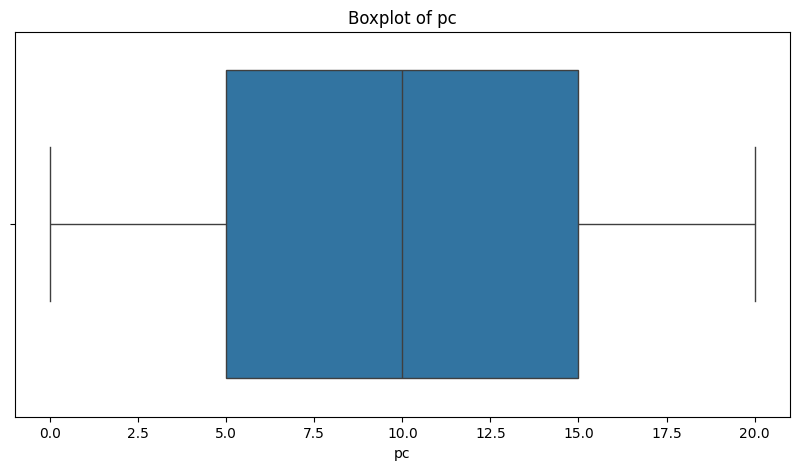

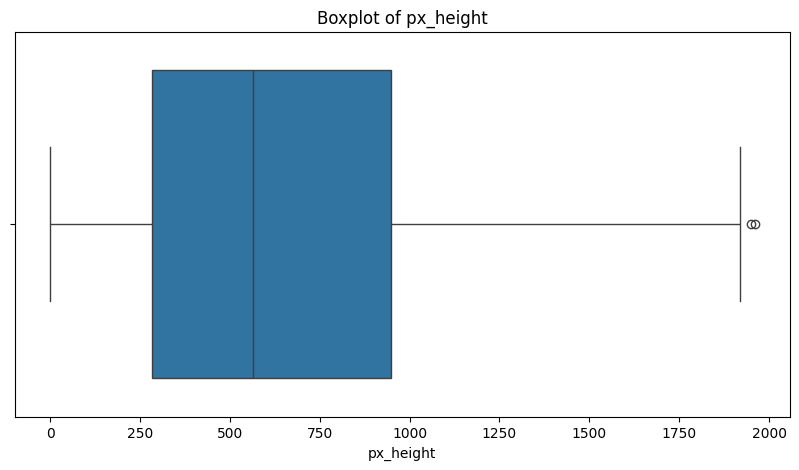

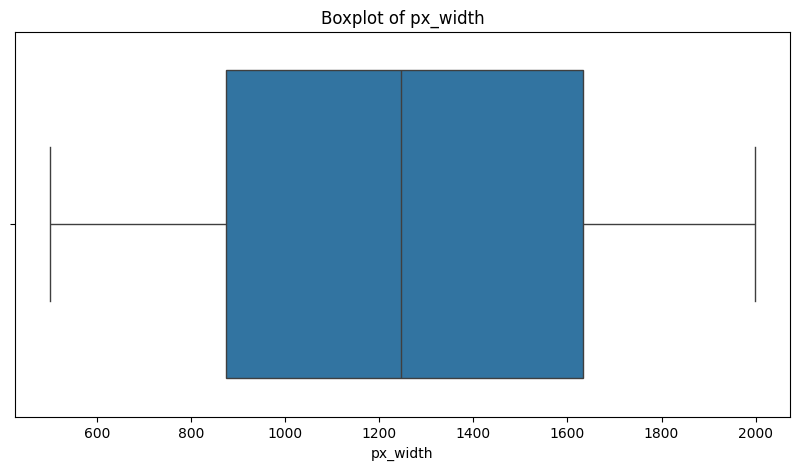

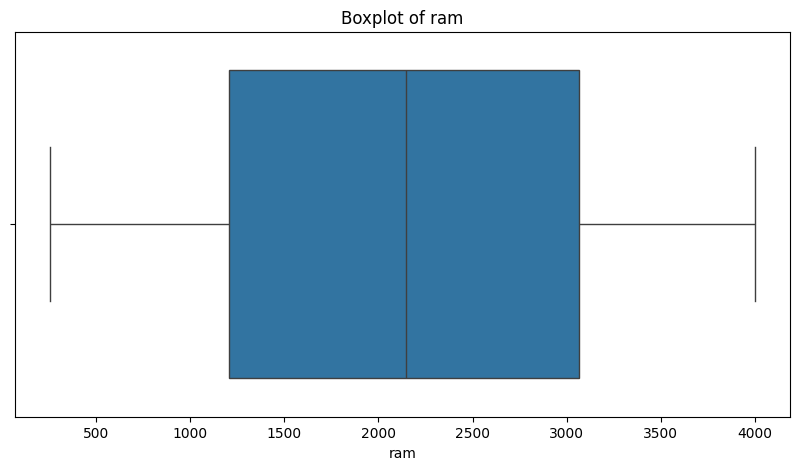

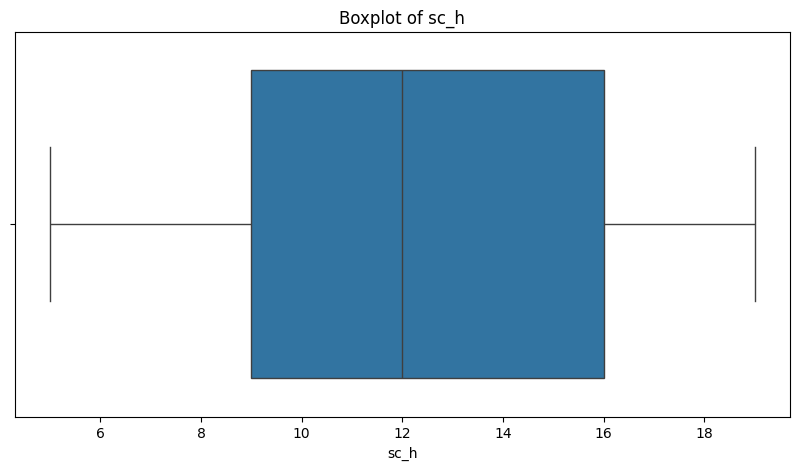

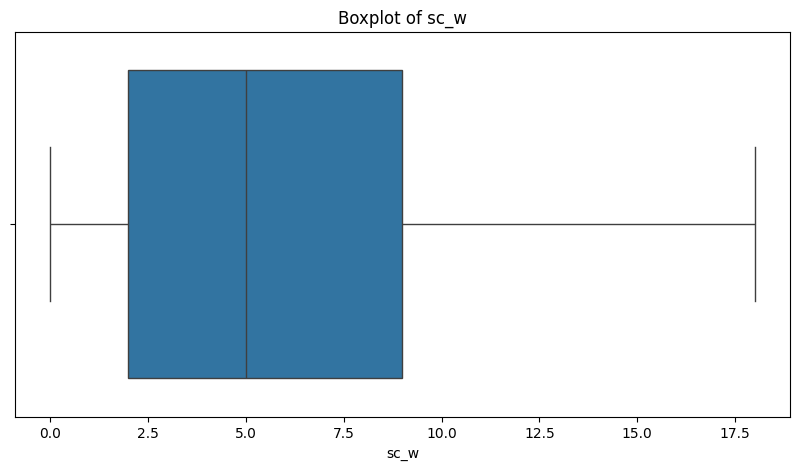

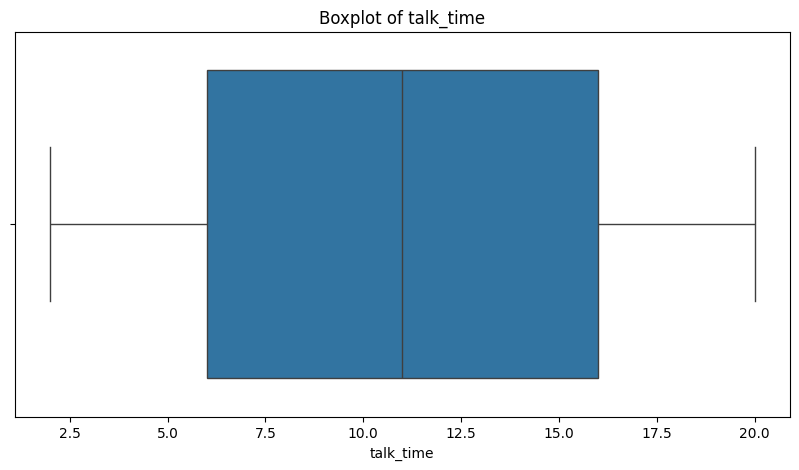

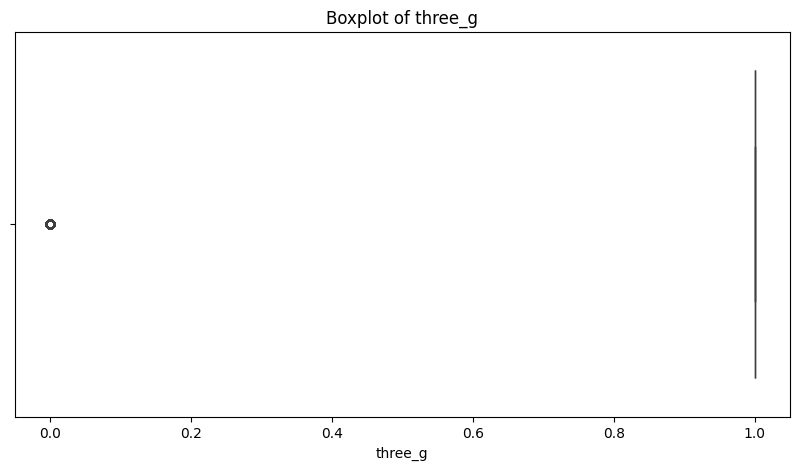

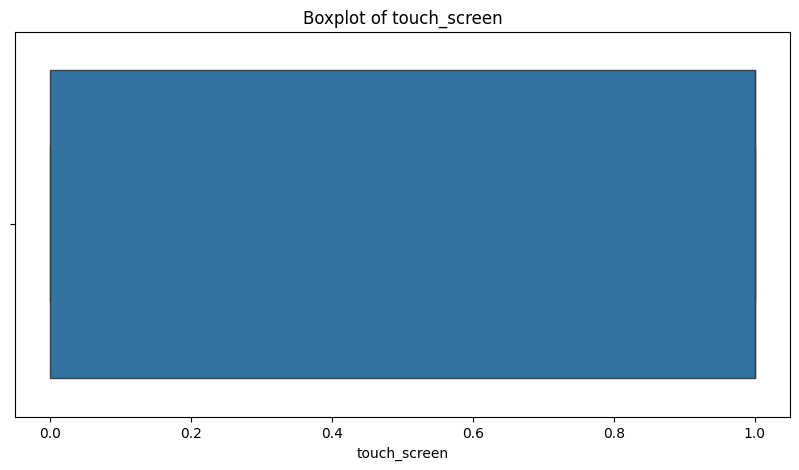

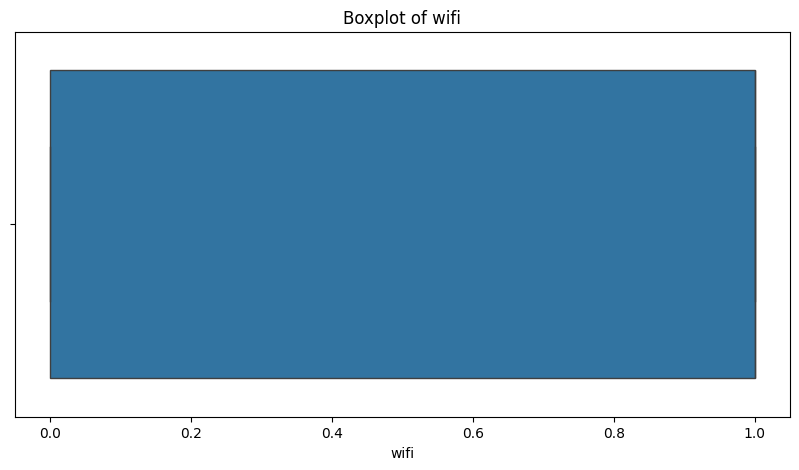

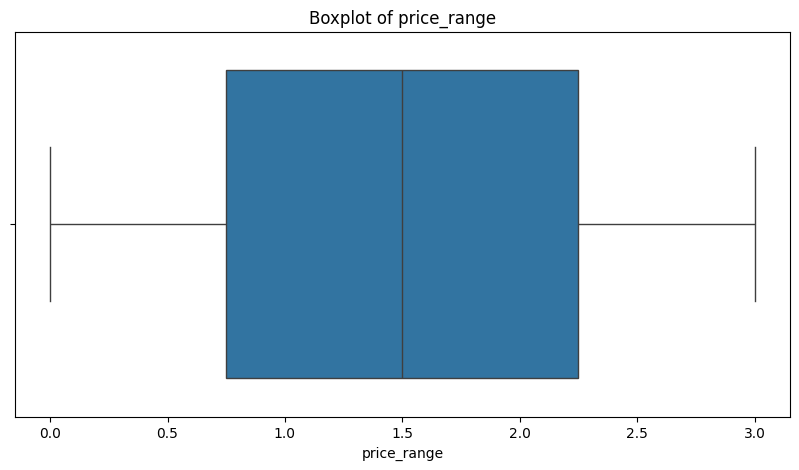

In [26]:
for col in numeric_columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=data_train, x=col)
    plt.title(f'Boxplot of {col}')
    plt.show()

## Analise da Variavel Target (price_range)

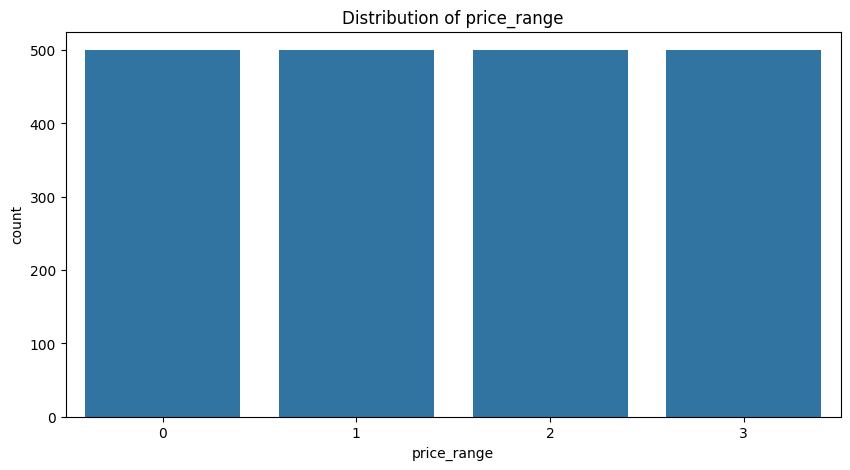

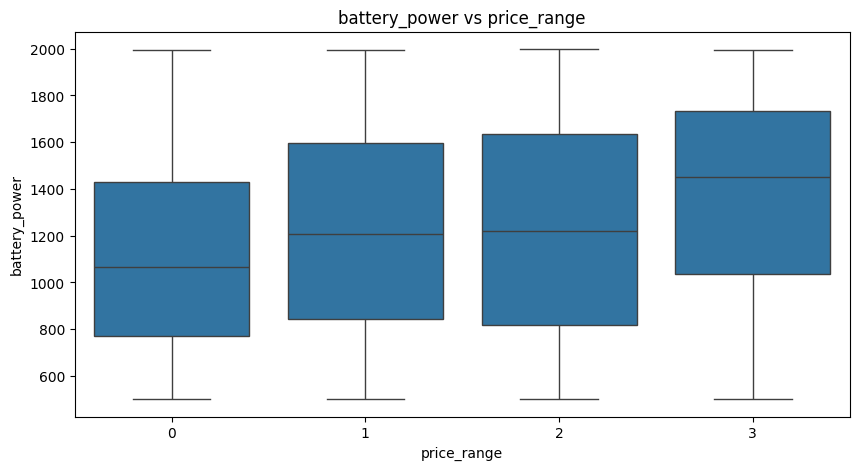

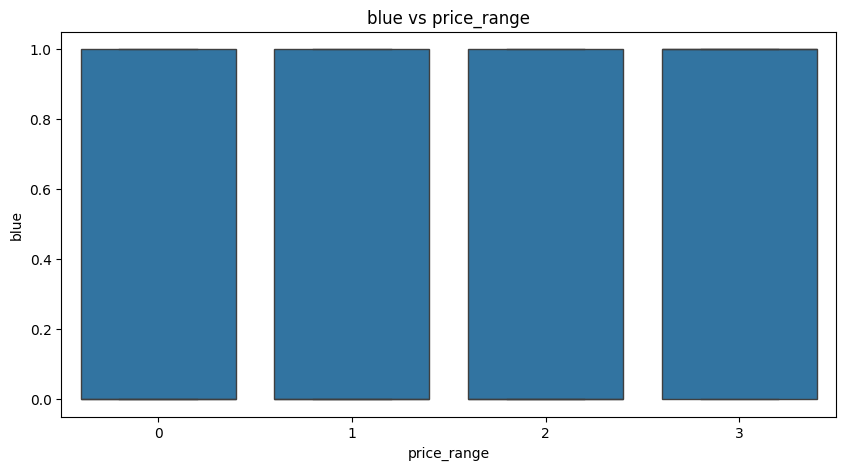

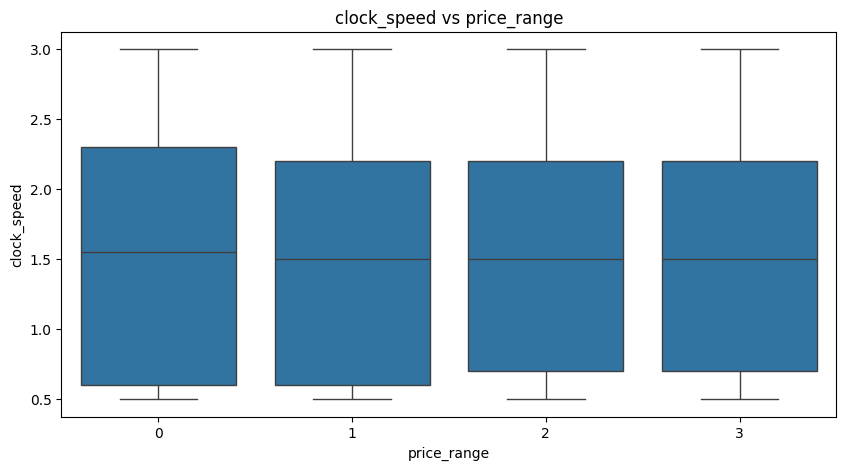

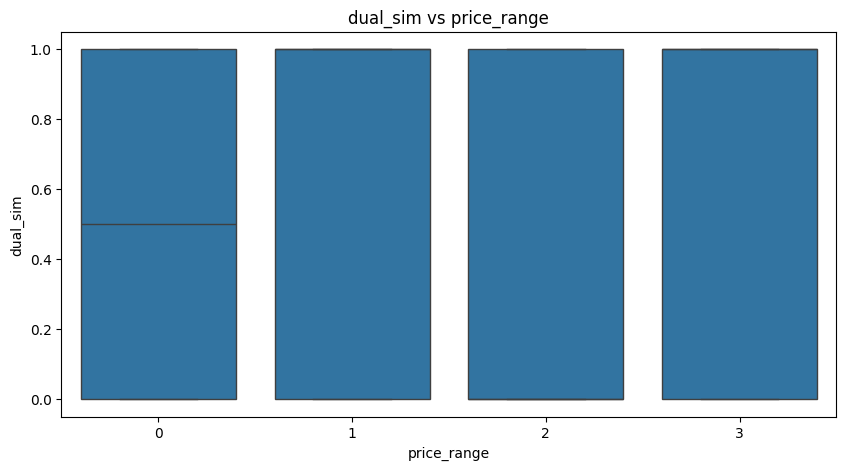

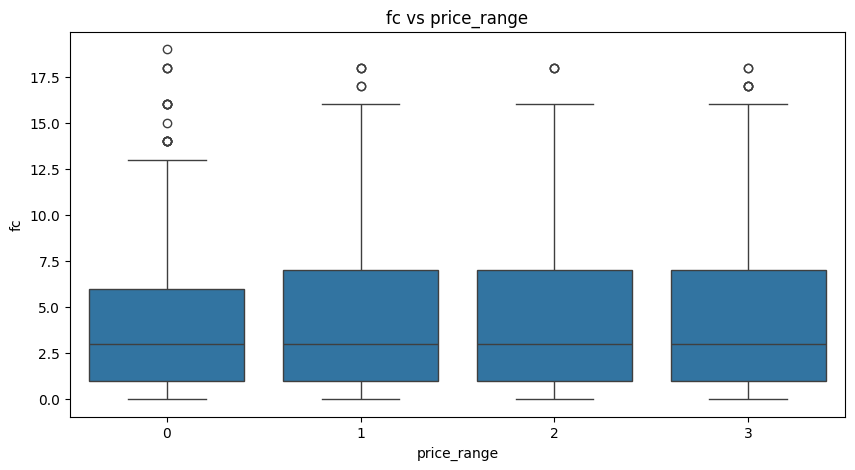

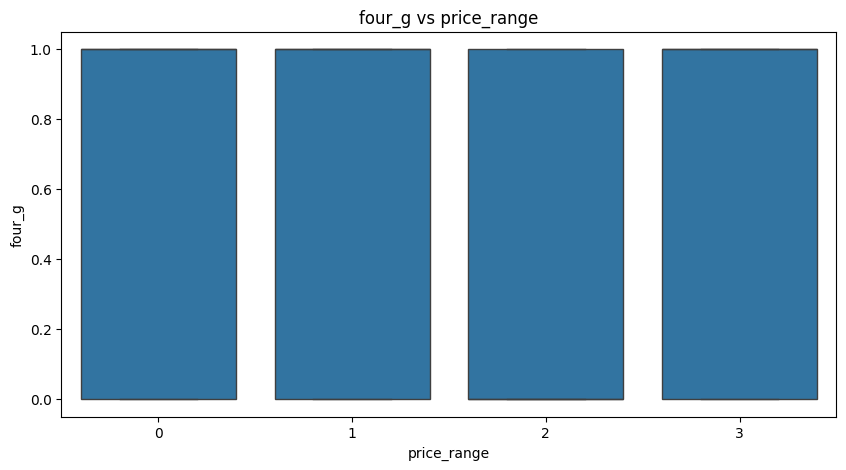

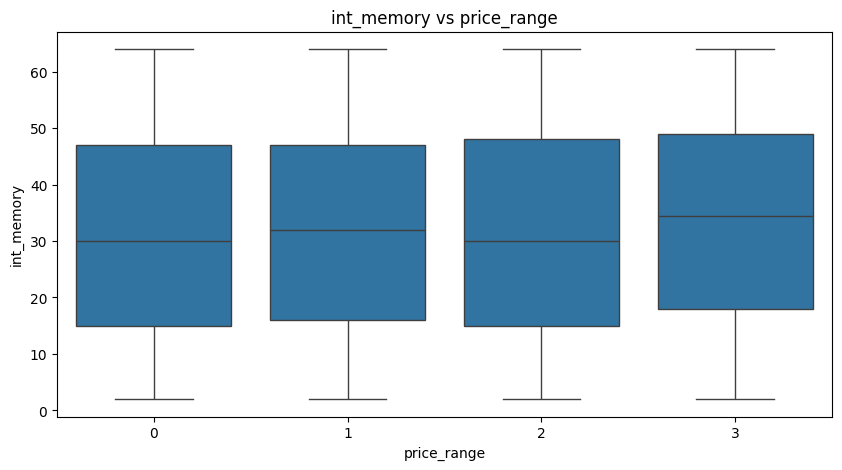

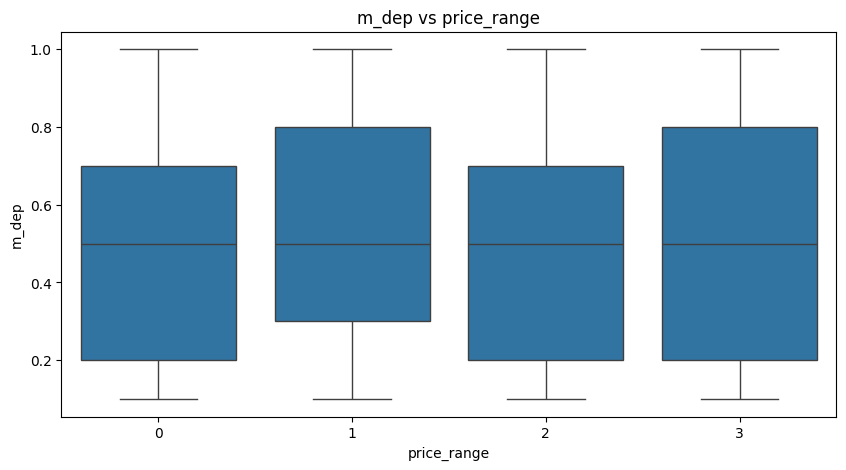

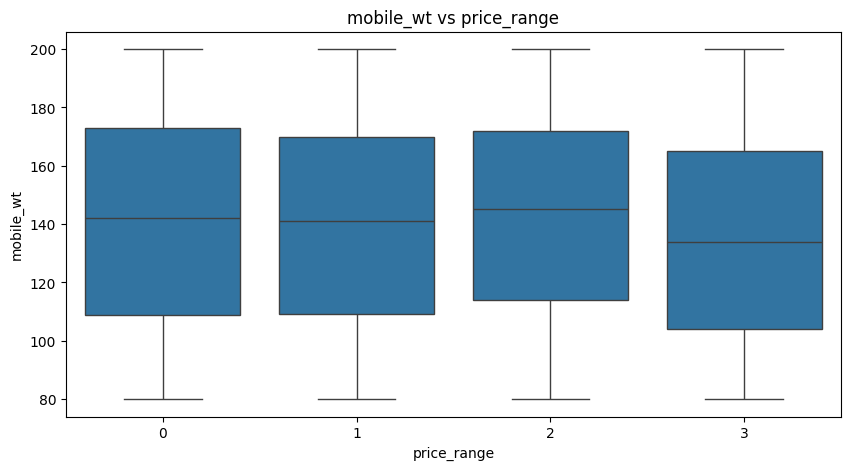

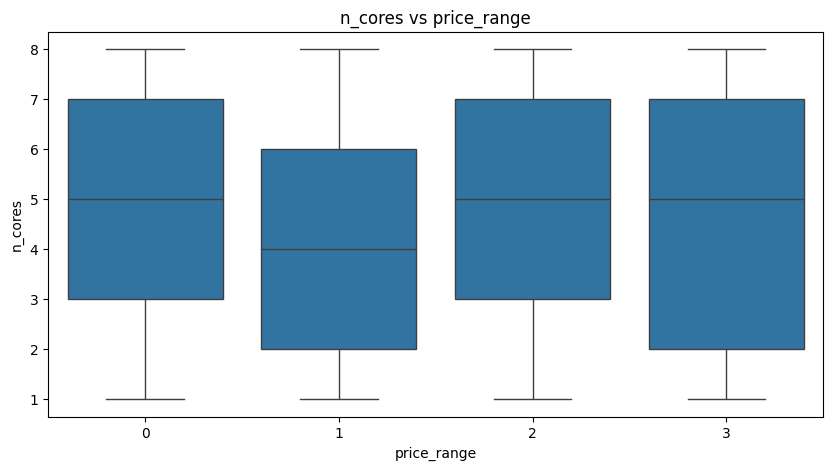

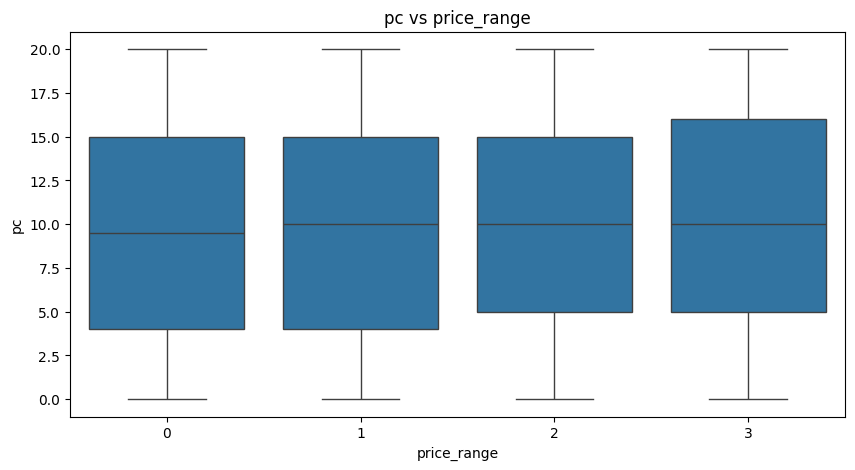

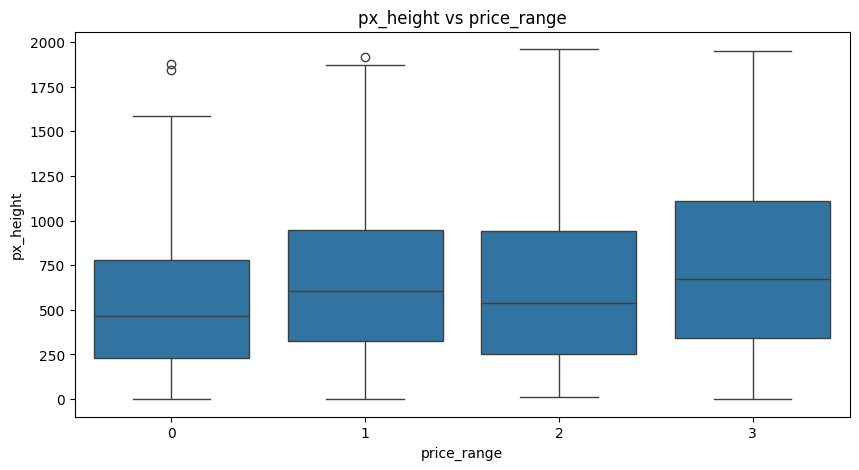

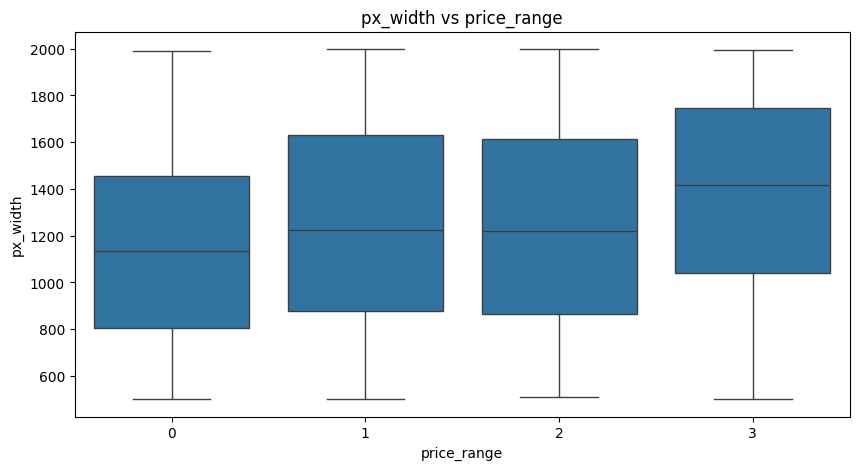

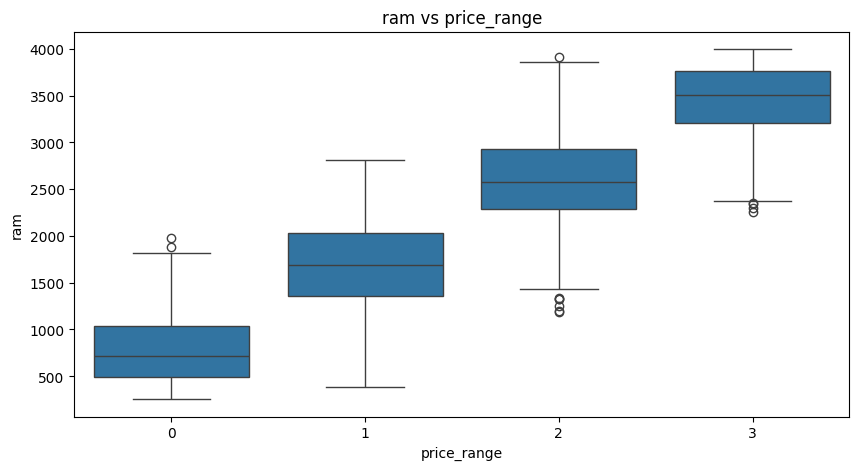

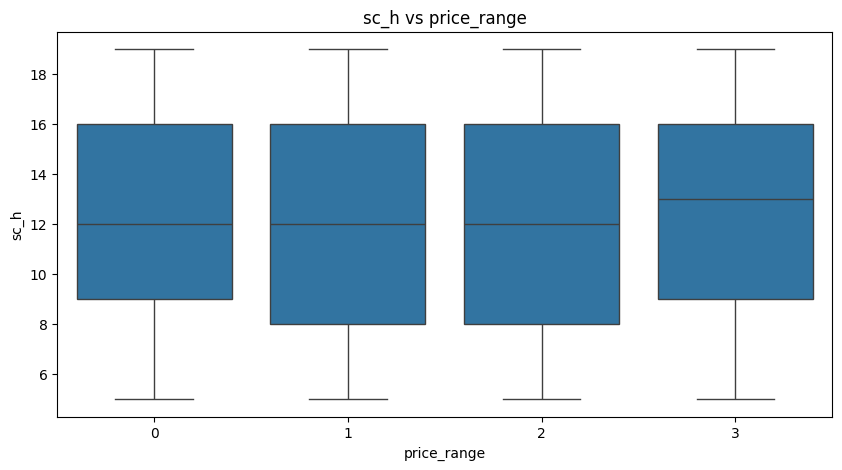

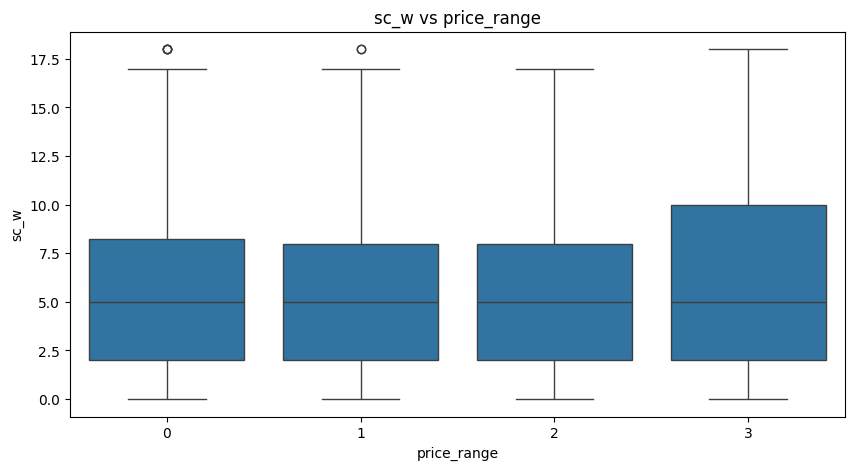

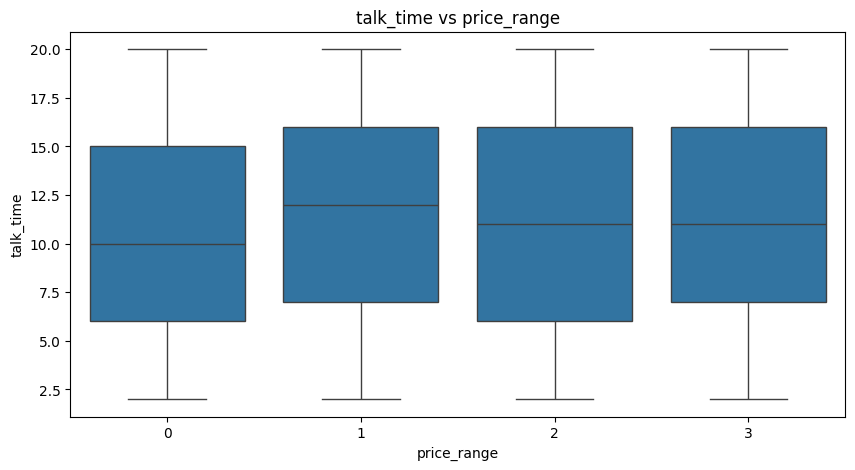

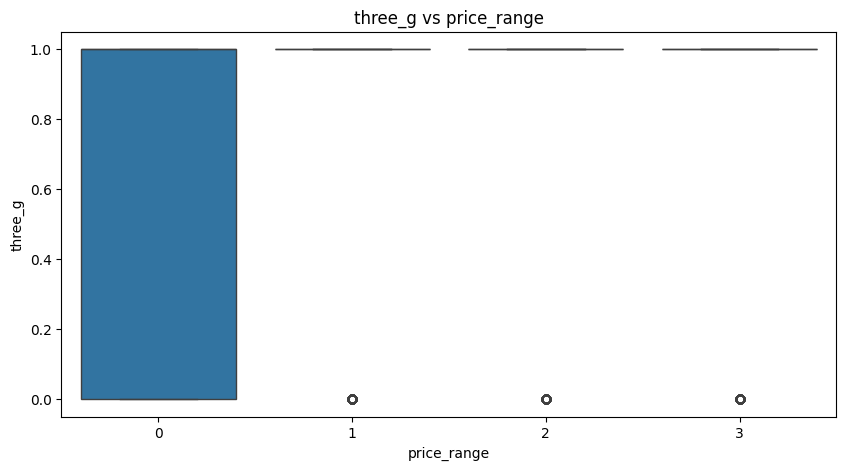

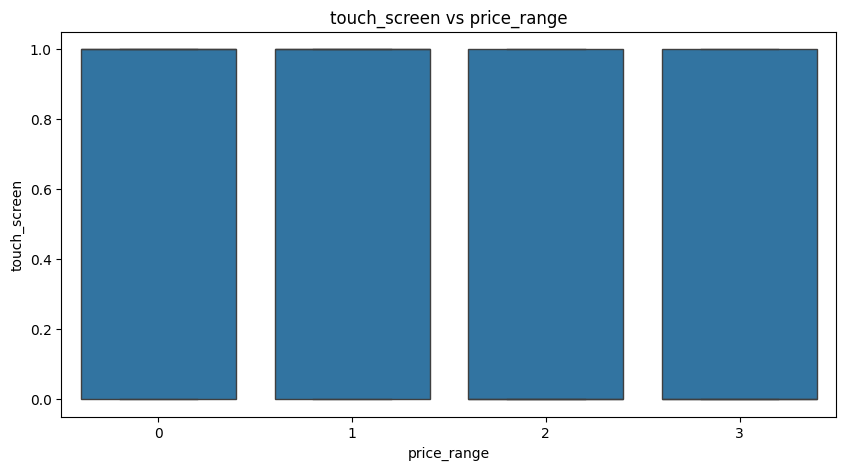

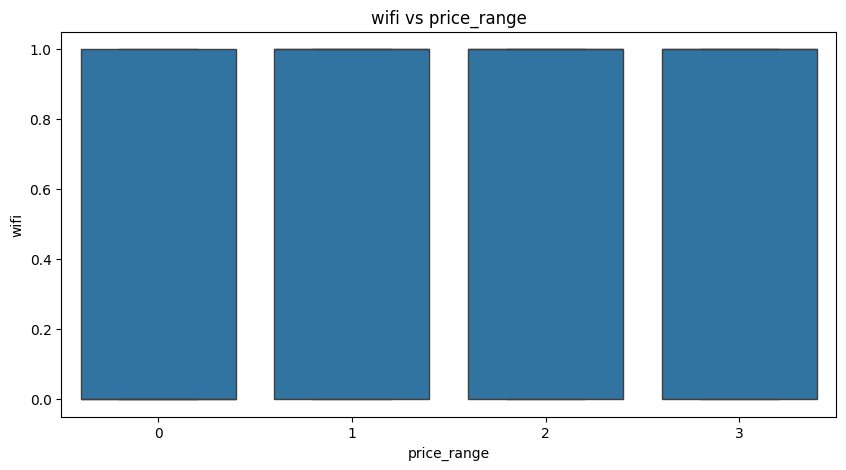

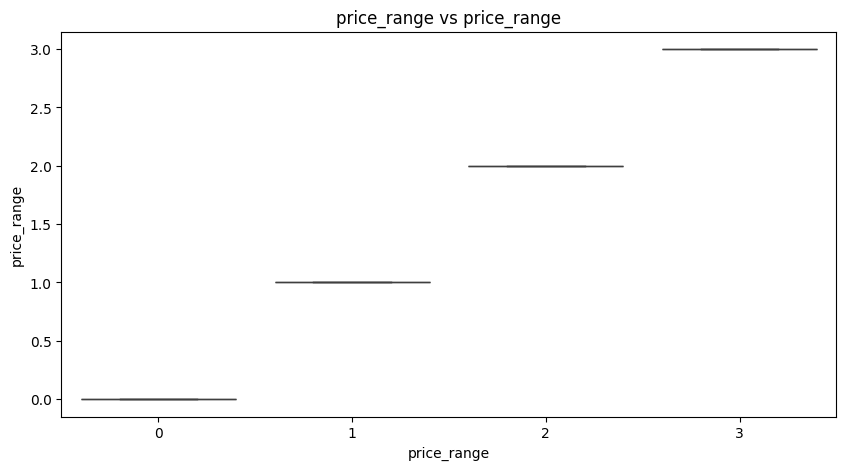

In [27]:
target_column = 'price_range'  # Substitua pelo nome da sua variável alvo

plt.figure(figsize=(10, 5))
sns.countplot(data=data_train, x=target_column)
plt.title(f'Distribution of {target_column}')
plt.show()

for col in numeric_columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=data_train, x=target_column, y=col)
    plt.title(f'{col} vs {target_column}')
    plt.show()

# Pré-processamento dos dados

In [22]:
# Tratar valores ausentes (se houver)
data_train.fillna(data_train.mean(), inplace=True)
data_test.fillna(data_test.mean(), inplace=True)

# Substituir valores zero pela média dentro de cada categoria de price_range
for col in ['sc_w', 'px_height']:
    data_train[col] = data_train.groupby('price_range')[col].transform(lambda x: x.replace(0, x.mean()))

# Codificar variáveis categóricas (se houver)
data_train = pd.get_dummies(data_train, drop_first=True)
data_test = pd.get_dummies(data_test, drop_first=True)

# Separar variáveis independentes e dependentes
X_train = data_train.drop('price_range', axis=1)
y_train = data_train['price_range']
X_test = data_test.drop('id', axis=1)

# Dividir o conjunto de treino para avaliação
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Normalizar os dados
scaler = StandardScaler()
X_train_split = scaler.fit_transform(X_train_split)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Treinamento dos modelos

## Regressão Logística

In [27]:
# Regressão Logística
log_reg = LogisticRegression(solver='newton-cg',max_iter=10000)
log_reg.fit(X_train_split, y_train_split)
y_pred_log_reg = log_reg.predict(X_val)

## Árvore de Decisão

In [28]:
# Árvore de Decisão
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train_split, y_train_split)
y_pred_tree = tree_clf.predict(X_val)

## Define o k-fold cross-validation

In [25]:
# Definindo o StratifiedKFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Calculando as pontuações com cross_val_score
log_reg_scores = cross_val_score(log_reg, X_train, y_train, cv=kf)
tree_clf_scores = cross_val_score(tree_clf, X_train, y_train, cv=kf)

# Avaliação e comparação dos resultados

In [29]:
# Avaliação e comparação dos resultados
accuracy_log_reg = accuracy_score(y_val, y_pred_log_reg)
accuracy_tree = accuracy_score(y_val, y_pred_tree)

print("Logistic Regression k-fold scores:", log_reg_scores)
print("Decision Tree k-fold scores:", tree_clf_scores)

# Calculando a média das pontuações
log_reg_mean_score = np.mean(log_reg_scores)
tree_clf_mean_score = np.mean(tree_clf_scores)

print(f"\nLogistic Regression Mean Score K-Fold: {log_reg_mean_score:.2f}")
print(f"Decision Tree Mean Score K-Fold: {tree_clf_mean_score:.2f}")

print("\nAccuracy of Logistic Regression:", accuracy_log_reg)
print("Accuracy of Decision Tree:", accuracy_tree)

print("\nClassification Report for Logistic Regression:\n", classification_report(y_val, y_pred_log_reg))
print("\nClassification Report for Decision Tree:\n", classification_report(y_val, y_pred_tree))

# Previsão dos valores de price_range para o conjunto de teste
y_test_pred_log_reg = log_reg.predict(X_test)
y_test_pred_tree = tree_clf.predict(X_test)

Logistic Regression k-fold scores: [0.9775 0.9775 0.965  0.9675 0.9725]
Decision Tree k-fold scores: [0.8275 0.815  0.855  0.8425 0.8525]

Logistic Regression Mean Score K-Fold: 0.97
Decision Tree Mean Score K-Fold: 0.84

Accuracy of Logistic Regression: 0.98
Accuracy of Decision Tree: 0.825

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       105
           1       0.96      1.00      0.98        91
           2       0.99      0.95      0.97        92
           3       0.97      0.99      0.98       112

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400


Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91       105
           1       0.74      0.79      0.77        91
           2     

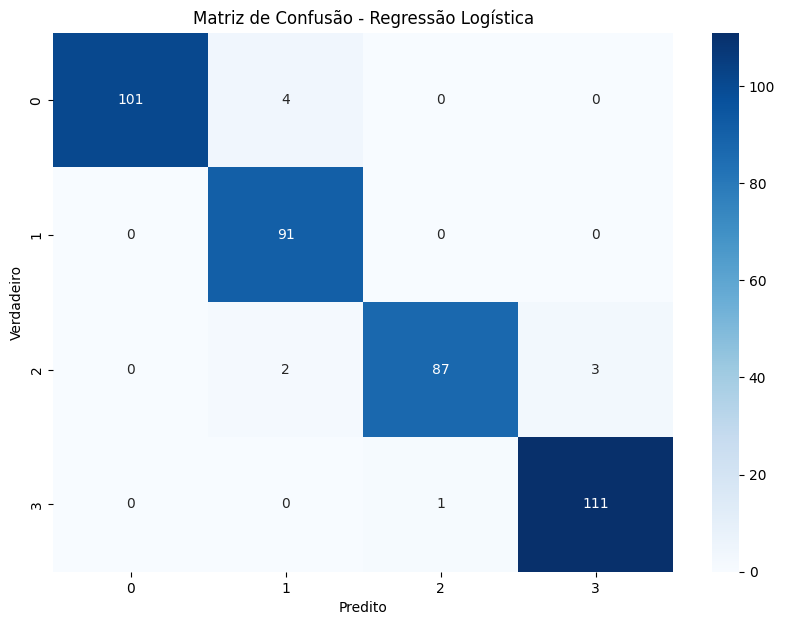

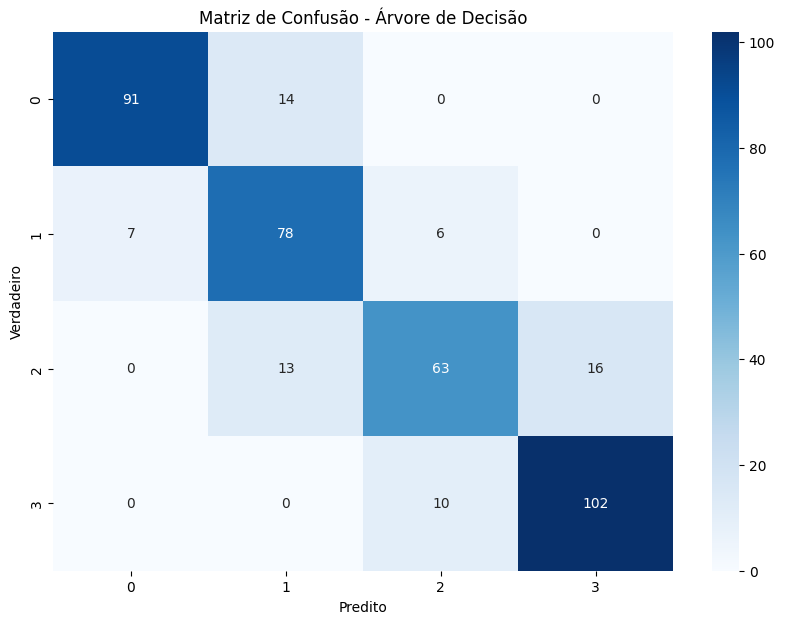

In [49]:
# Matriz de confusão para Regressão Logística
cm_log_reg = confusion_matrix(y_val, y_pred_log_reg)

# Mapa de calor para Regressão Logística
plt.figure(figsize=(10, 7))
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Regressão Logística')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# Matriz de confusão para Árvore de Decisão
cm_tree = confusion_matrix(y_val, y_pred_tree)
# Mapa de calor para Árvore de Decisão
plt.figure(figsize=(10, 7))
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Árvore de Decisão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

In [35]:
# Lista de atributos contínuos
continuous_attributes = [
    'battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 
    'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 
    'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi'
]

# Dicionário para armazenar os resultados
anova_results = []

# Iterar sobre cada atributo contínuo
for attribute in continuous_attributes:
    # Separar os grupos com base no price_range
    groups = [data_train[data_train['price_range'] == label][attribute] for label in data_train['price_range'].unique()]
    
    # Realizar o teste ANOVA
    f_statistic, p_value = f_oneway(*groups)
    
    # Armazenar os resultados
    anova_results.append({'Attribute': attribute, 'F-Statistic': f_statistic, 'P-Value': p_value})

# Criar um DataFrame para exibir os resultados
anova_df = pd.DataFrame(anova_results)

# Classificar os resultados pelo valor do F-Statistic em ordem decrescente
anova_df = anova_df.sort_values(by='F-Statistic', ascending=False).reset_index(drop=True)

# Exibir os resultados
print(anova_df)

        Attribute  F-Statistic       P-Value
0             ram  3520.110824  0.000000e+00
1   battery_power    31.598158  5.948688e-20
2        px_width    22.620882  2.116911e-14
3       px_height    19.847558  1.121547e-12
4       mobile_wt     3.594318  1.311739e-02
5      int_memory     2.922996  3.277694e-02
6         n_cores     2.625415  4.893585e-02
7            sc_h     2.225984  8.324991e-02
8       talk_time     1.628811  1.806686e-01
9            sc_w     1.627907  1.808765e-01
10          m_dep     1.500682  2.124595e-01
11   touch_screen     1.293302  2.750433e-01
12         four_g     1.059525  3.651552e-01
13             pc     0.825446  4.797489e-01
14             fc     0.772182  5.095042e-01
15    clock_speed     0.493708  6.866752e-01
16           blue     0.476768  6.984831e-01
17        three_g     0.457320  7.121507e-01
18       dual_sim     0.428239  7.327869e-01
19           wifi     0.284940  8.363070e-01
